In [1]:
%load_ext ipybind
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

import sys
import os

libst_path = os.path.abspath('spacetime')
if libst_path not in sys.path:
    sys.path.insert(0, libst_path)

import libst

# Pybind11: binding between Python and C++

1. Why do we use scripting
   1. Research code
   2. Full-fledged application
   3. Scripting for modularization
2. Pybind11 build system
   1. Setuptools
   2. Cmake with a sub-directory
   3. Cmake with install pybind11
3. Additional wrapping layer for customization
4. Wrapping API
   1. Functions and property
   2. Named ane keyword arguments
   3. What happens in Python stays in Python (or pybind11)
5. See how Python plays
   1. Linear wave
   2. The inviscid Burgers equation
6. Manipulate Python objects in C++
7. Python containers
   1. `tuple`
   2. `list`
   3. `dict`

# Why do we use scripting

Computing is about commanding the computers to perform calculations to yeild the results that we want to see.  We want to delegate work to computers as much as possible, when the system performance remains feasible.

In the calculations, scripting plays an important role.  A general architecture of numerical software has the following layers, from high-level to low-level:

* External result
  * This is presented in a non-technical way to people outside the problem-solving team.  They can be stakeholders for business or general public.  The result has to be generated in some way, which may or may not be included in the numerical software we make.
* Problem presentation: physics, math, or equations
  * Users use the software or associated tools to present the technical result.
* Scripting or configuration
  * Users follow the example scripts to configure the problems to solve.  Configuration files may also be used.
* Library interface
  * This defines the application programming interface (API) for the numerical software.  Scripts should not touch anything below this layer.
* Library structure
  * This is where we architect the software.  Good book-keeping code is here to separate the interface and the computing kernel.  Data structures are designed at this layer to make sure no time is wasted in copying or converting data.
* Computing kernel
  * This is the place the does the heavy-lifting, and where we do most of the optimization.

## Research code

For a research code, the boundary between external result, problem presentation, and scripting, and that between library interface, library structure, and computing kernel, may be less clear.  The architecture is usually like:

* Problem presentation: high-level description, physics, and scripting / code configuration
* Library implementation

But sometimes if we don't pay attention to architecting, there may be no boundary between anything.

## Full-fledged application

For a commercial grade package, each of the layers will include more sub-layers.  It is a challenge to prevent those layers or sub-layers from interweaving.  From users' point of view, the sophistication appears in the problem presentation and the scripting layers.  Developers, on the other hand, take care of everything below problem presentation, so that users can focus on problem solving.

## Scripting for modularization

At this point, it should be clear that the scripting layer is the key glue in the system architecture.  The high-level users, who use the code for problem solving, wouldn't want to spend time in the low-level implementation.  Instead, they will specify the performance of the API exposed in the scripting layer.  The performance may be about the quality of result and runtime (including memory).

The scripting layer can separate the programming work between the high-level problem presentation and the low-level library implementation.  A scripting language is usually dynamically typed, while for speed, the low-level implementation language uses static typing system.  In the dynamic scripting language, unit-testing is required for robustness.  In a statically typed language like C++, the compiler and static analyzers are very good at detecting errors before runtime.  But the great job done by the compiler makes it clumsy to use C++ to quickly write highly flexible code for problem presentation.

It is tempting to invent one programming language to rule them all.  That approach needs to convince both the high-level problem solvers and the low-level implementors to give up the tools they are familiar with.  The new language will also need to provide two distinct styles for both use cases.  It will be quite challenging, and before anyone succeeds with the one-language approach, we still need to live with a world of hybrid systems.

# Pybind11 build system

[Pybind11](https://pybind11.readthedocs.io/) is a header-only C++ template library, that allows calling CPython API and provides C++ friendly semantics to allow Python to call C++ constructs and vise versa.

Pybind11 is a header-only library, so it doesn't have anything to be built.  When we say 'building' pybind11, we mean to build the project that uses pybind11.

To build pybind11, we need CPython.  It optionally depends on numpy and eigen.  There are several suggested ways to build.  Here list those I think important:

## [Setuptools](https://setuptools.readthedocs.io/en/latest/)

[Setuptools](https://setuptools.readthedocs.io/en/latest/) is an enhancement to Python built-in [distutils](https://docs.python.org/3/library/distutils.html).  Because pybind11 is released to [PyPI](https://pypi.org) as a Python package (https://pypi.org/project/pybind11/), both setuptools and distutils can get the header files and use them to build C++ file that use pybind11.

There is an example for using setuptools to build pybind11 (https://github.com/pybind/python_example/blob/master/setup.py):

```python
from setuptools import setup, Extension
from setuptools.command.build_ext import build_ext
import sys
import setuptools

__version__ = '0.0.1'


class get_pybind_include(object):
    """Helper class to determine the pybind11 include path
    The purpose of this class is to postpone importing pybind11
    until it is actually installed, so that the ``get_include()``
    method can be invoked. """

    def __init__(self, user=False):
        self.user = user

    def __str__(self):
        import pybind11
        return pybind11.get_include(self.user)


ext_modules = [
    Extension(
        'python_example',
        ['src/main.cpp'],
        include_dirs=[
            # Path to pybind11 headers
            get_pybind_include(),
            get_pybind_include(user=True)
        ],
        language='c++'
    ),
]


# As of Python 3.6, CCompiler has a `has_flag` method.
# cf http://bugs.python.org/issue26689
def has_flag(compiler, flagname):
    """Return a boolean indicating whether a flag name is supported on
    the specified compiler.
    """
    import tempfile
    with tempfile.NamedTemporaryFile('w', suffix='.cpp') as f:
        f.write('int main (int argc, char **argv) { return 0; }')
        try:
            compiler.compile([f.name], extra_postargs=[flagname])
        except setuptools.distutils.errors.CompileError:
            return False
    return True


def cpp_flag(compiler):
    """Return the -std=c++[11/14/17] compiler flag.
    The newer version is prefered over c++11 (when it is available).
    """
    flags = ['-std=c++17', '-std=c++14', '-std=c++11']

    for flag in flags:
        if has_flag(compiler, flag): return flag

    raise RuntimeError('Unsupported compiler -- at least C++11 support '
                       'is needed!')


class BuildExt(build_ext):
    """A custom build extension for adding compiler-specific options."""
    c_opts = {
        'msvc': ['/EHsc'],
        'unix': [],
    }
    l_opts = {
        'msvc': [],
        'unix': [],
    }

    if sys.platform == 'darwin':
        darwin_opts = ['-stdlib=libc++', '-mmacosx-version-min=10.7']
        c_opts['unix'] += darwin_opts
        l_opts['unix'] += darwin_opts

    def build_extensions(self):
        ct = self.compiler.compiler_type
        opts = self.c_opts.get(ct, [])
        link_opts = self.l_opts.get(ct, [])
        if ct == 'unix':
            opts.append('-DVERSION_INFO="%s"' % self.distribution.get_version())
            opts.append(cpp_flag(self.compiler))
            if has_flag(self.compiler, '-fvisibility=hidden'):
                opts.append('-fvisibility=hidden')
        elif ct == 'msvc':
            opts.append('/DVERSION_INFO=\\"%s\\"' % self.distribution.get_version())
        for ext in self.extensions:
            ext.extra_compile_args = opts
            ext.extra_link_args = link_opts
        build_ext.build_extensions(self)

setup(
    name='python_example',
    version=__version__,
    author='Sylvain Corlay',
    author_email='sylvain.corlay@gmail.com',
    url='https://github.com/pybind/python_example',
    description='A test project using pybind11',
    long_description='',
    ext_modules=ext_modules,
    install_requires=['pybind11>=2.4'],
    setup_requires=['pybind11>=2.4'],
    cmdclass={'build_ext': BuildExt},
    zip_safe=False,
)```

## Cmake with a sub-directory

When the source tree is put in a sub-directory in your project, as mentioned in the [document](https://pybind11.readthedocs.io/en/stable/compiling.html#building-with-cmake), you can use cmake `add_subdirectory` to include the pybind11:

```cmake
cmake_minimum_required(VERSION 2.8.12)
project(example)

add_subdirectory(pybind11)
pybind11_add_module(example example.cpp)
```

Pybind11 provides the cmake command `pybind11_add_module`.  It set various flags to build your C++ code as an extension module.

## Cmake with installed pybind11

If pybind11 is installed using cmake itself, the `*.cmake` files that pybind11 supplies are installed to the specified location.  It's not needed to write `add_subdirectory` in the `CMakeLists.txt` in your project.

# Additional wrapping layer for customization

Wrapper needs to take care of the differences between the dynamic behaviors in Python and the staticity in C++.  You can directly call pybind11 API.  But a better way is to create another wrapping layer between the pybind11 and your library code.  It allows us to insert additional code in a systematic way.  Since it is difficult to see the point in a small example, I pull the code for [a bigger project 'turgon'](https://github.com/yungyuc/turgon) for demonstration.

Here is one way to implement the additional wrapping layer.  See `spacetime/include/spacetime/python/WrapBase.hpp`:

```cpp
#pragma once

/*
 * Copyright (c) 2017, Yung-Yu Chen <yyc@solvcon.net>
 * BSD 3-Clause License, see COPYING
 */

#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>
#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
#include <numpy/arrayobject.h>

#include <memory>
#include <type_traits>

PYBIND11_DECLARE_HOLDER_TYPE(T, std::unique_ptr<T>);
PYBIND11_DECLARE_HOLDER_TYPE(T, std::shared_ptr<T>);

#ifdef __GNUG__
#  define SPACETIME_PYTHON_WRAPPER_VISIBILITY __attribute__((visibility("hidden")))
#else
#  define SPACETIME_PYTHON_WRAPPER_VISIBILITY
#endif

namespace spacetime
{

namespace python
{

/**
 * Helper template for pybind11 class wrappers.
 */
template< class Wrapper, class Wrapped, class Holder = std::unique_ptr<Wrapped>, class WrappedBase = Wrapped >
class
SPACETIME_PYTHON_WRAPPER_VISIBILITY
WrapBase {

public:

    using wrapper_type = Wrapper;
    using wrapped_type = Wrapped;
    using wrapped_base_type = WrappedBase;
    using holder_type = Holder;
    using base_type = WrapBase< wrapper_type, wrapped_type, holder_type, wrapped_base_type >;
    using class_ = typename std::conditional<
        std::is_same< Wrapped, WrappedBase >::value
      , pybind11::class_< wrapped_type, holder_type >
      , pybind11::class_< wrapped_type, wrapped_base_type, holder_type >
    >::type;

    static wrapper_type & commit(pybind11::module * mod, const char * pyname, const char * clsdoc) {
        static wrapper_type derived(mod, pyname, clsdoc);
        return derived;
    }

    WrapBase() = delete;
    WrapBase(WrapBase const & ) = default;
    WrapBase(WrapBase       &&) = delete;
    WrapBase & operator=(WrapBase const & ) = default;
    WrapBase & operator=(WrapBase       &&) = delete;
    ~WrapBase() = default;

#define DECL_ST_PYBIND_CLASS_METHOD(METHOD) \
    template< class... Args > \
    /* NOLINTNEXTLINE(bugprone-macro-parentheses) */ \
    wrapper_type & METHOD(Args&&... args) { \
        m_cls.METHOD(std::forward<Args>(args)...); \
        return *static_cast<wrapper_type*>(this); \
    }

    DECL_ST_PYBIND_CLASS_METHOD(def)
    DECL_ST_PYBIND_CLASS_METHOD(def_readwrite)
    DECL_ST_PYBIND_CLASS_METHOD(def_property)
    DECL_ST_PYBIND_CLASS_METHOD(def_property_readonly)
    DECL_ST_PYBIND_CLASS_METHOD(def_property_readonly_static)

#undef DECL_ST_PYBIND_CLASS_METHOD

protected:

    WrapBase(pybind11::module * mod, const char * pyname, const char * clsdoc)
      : m_cls(*mod, pyname, clsdoc)
    {}

private:

    class_ m_cls;

}; /* end class WrapBase */

} /* end namespace python */

} /* end namespace spacetime */

/* vim: set et ts=4 sw=4: */
```

Use `WrapGrid`, `WrapField`, `WrapSolver`, `WrapCelm`, and `WrapSelm` to show how `WrapBase` is used.  See `spacetime/include/spacetime/python/wrapper_spacetime.hpp`:

```c++
#pragma once

/*
 * Copyright (c) 2018, Yung-Yu Chen <yyc@solvcon.net>
 * BSD 3-Clause License, see COPYING
 */

#include "spacetime/python/common.hpp"

namespace spacetime
{

namespace python
{

class
SPACETIME_PYTHON_WRAPPER_VISIBILITY
WrapGrid
  : public WrapBase< WrapGrid, Grid, std::shared_ptr<Grid> >
{

    friend base_type;

    WrapGrid(pybind11::module * mod, const char * pyname, const char * clsdoc)
      : base_type(mod, pyname, clsdoc)
    {
        namespace py = pybind11;
        (*this)
            .def(
                py::init([](real_type xmin, real_type xmax, size_t nelm) {
                    return Grid::construct(xmin, xmax, nelm);
                }),
                py::arg("xmin"), py::arg("xmax"), py::arg("nelm")
            )
            .def(
                py::init([](xt::pyarray<wrapped_type::value_type> & xloc) {
                    return Grid::construct(xloc);
                }),
                py::arg("xloc")
            )
            .def("__str__", &detail::to_str<wrapped_type>)
            .def_property_readonly("xmin", &wrapped_type::xmin)
            .def_property_readonly("xmax", &wrapped_type::xmax)
            .def_property_readonly("ncelm", &wrapped_type::ncelm)
            .def_property_readonly("nselm", &wrapped_type::nselm)
            .def_property_readonly(
                "xcoord",
                static_cast<wrapped_type::array_type & (wrapped_type::*)()>(&wrapped_type::xcoord)
            )
            .def_property_readonly_static("BOUND_COUNT", [](py::object const &){ return Grid::BOUND_COUNT; })
        ;
    }

}; /* end class WrapGrid */

class
SPACETIME_PYTHON_WRAPPER_VISIBILITY
WrapField
  : public WrapBase< WrapField, Field, std::shared_ptr<Field> >
{

    friend base_type;

    WrapField(pybind11::module * mod, const char * pyname, const char * clsdoc)
      : base_type(mod, pyname, clsdoc)
    {
        namespace py = pybind11;
        (*this)
            .def("__str__", &detail::to_str<wrapped_type>)
            .def_property_readonly("grid", [](wrapped_type & self){ return self.grid().shared_from_this(); })
            .def_property_readonly("nvar", &wrapped_type::nvar)
            .def_property(
                "time_increment",
                &wrapped_type::time_increment,
                &wrapped_type::set_time_increment
             )
            .def_property_readonly("dt", &wrapped_type::dt)
            .def_property_readonly("hdt", &wrapped_type::hdt)
            .def_property_readonly("qdt", &wrapped_type::qdt)
            .def(
                "celm",
                static_cast<Celm (wrapped_type::*)(sindex_type, bool)>(&wrapped_type::celm_at<Celm>),
                py::arg("ielm"), py::arg("odd_plane")=false
            )
            .def(
                "selm",
                static_cast<Selm (wrapped_type::*)(sindex_type, bool)>(&wrapped_type::selm_at<Selm>),
                py::arg("ielm"), py::arg("odd_plane")=false
            )
        ;
    }

}; /* end class WrapField */

class
SPACETIME_PYTHON_WRAPPER_VISIBILITY
WrapSolver
  : public WrapSolverBase< WrapSolver, Solver >
{

    using base_type = WrapSolverBase< WrapSolver, Solver >;
    using wrapper_type = typename base_type::wrapper_type;
    using wrapped_type = typename base_type::wrapped_type;

    friend base_type;
    friend base_type::base_type;

    WrapSolver(pybind11::module * mod, const char * pyname, const char * clsdoc)
      : base_type(mod, pyname, clsdoc)
    {
        namespace py = pybind11;
        (*this)
            .def
            (
                py::init(static_cast<std::shared_ptr<wrapped_type> (*) (
                    std::shared_ptr<Grid> const &, typename wrapped_type::value_type, size_t
                )>(&wrapped_type::construct))
              , py::arg("grid"), py::arg("time_increment"), py::arg("nvar")
            )
        ;
    }

}; /* end class WrapSolver */

class
SPACETIME_PYTHON_WRAPPER_VISIBILITY
WrapCelm
  : public WrapCelmBase< WrapCelm, Celm >
{

    using base_type = WrapCelmBase< WrapCelm, Celm >;
    friend base_type::base_type::base_type;

    WrapCelm(pybind11::module * mod, const char * pyname, const char * clsdoc)
      : base_type(mod, pyname, clsdoc)
    {}

}; /* end class WrapCelm */

class
SPACETIME_PYTHON_WRAPPER_VISIBILITY
WrapSelm
  : public WrapSelmBase< WrapSelm, Selm >
{

    using base_type = WrapSelmBase< WrapSelm, Selm >;
    friend base_type::base_type::base_type;

    WrapSelm(pybind11::module * mod, const char * pyname, const char * clsdoc)
      : base_type(mod, pyname, clsdoc)
    {}

}; /* end class WrapSelm */

} /* end namespace python */

} /* end namespace spacetime */

// vim: set et sw=4 ts=4:
```

Note that the use of `WrapperBase` saves little duplicated code, if any.  But it facilitates to keep the `.cpp` file for building the Python extension (`spacetime/src/python/libst.cpp`) to be very short:

```cpp
/*
 * Copyright (c) 2018, Yung-Yu Chen <yyc@solvcon.net>
 * BSD 3-Clause License, see COPYING
 */

#include "spacetime/python.hpp" // must be first

#include "spacetime.hpp"

#include <algorithm>
#include <cstring>
#include <memory>
#include <utility>
#include <vector>

namespace
{

PyObject * initialize_spacetime(pybind11::module * mod)
{
    namespace spy = spacetime::python;
    xt::import_numpy(); // otherwise numpy c api segfault.
    mod->doc() = "_libst: One-dimensional space-time CESE method code";
    spy::WrapGrid::commit(mod, "Grid", "Spatial grid data");
    spy::WrapField::commit(mod, "Field", "Solution data");
    return mod->ptr();
}

} /* end namespace */

PYBIND11_MODULE(_libst, mod) // NOLINT
{
    namespace spy = spacetime::python;
    spy::ModuleInitializer::get_instance()
        .add(initialize_spacetime)
        .add_solver<spy::WrapSolver, spy::WrapCelm, spy::WrapSelm>
        (&mod, "", "no equation")
        .add_solver<spy::WrapLinearScalarSolver, spy::WrapLinearScalarCelm, spy::WrapLinearScalarSelm>
        (&mod, "LinearScalar", "a linear scalar equation")
        .add_solver<spy::WrapInviscidBurgersSolver, spy::WrapInviscidBurgersCelm, spy::WrapInviscidBurgersSelm>
        (&mod, "InviscidBurgers", "the inviscid Burgers equation")
        .initialize(&mod)
    ;
}

// vim: set et sw=4 ts=4:
```

# Wrapping API

Let's take a look at the helpers that pybind11 provides.

In [2]:
!make -C spacetime

mkdir -p build/dev37 ; \
	cd build/dev37 ; \
	cmake /Users/yungyuc/hack/code/nsd/notebook/pybind/spacetime \
		-DCMAKE_INSTALL_PREFIX=/Users/yungyuc/hack/code/nsd/notebook/pybind/spacetime \
		-DCMAKE_BUILD_TYPE=Release \
		-DHIDE_SYMBOL=OFF \
		-DDEBUG_SYMBOL=ON \
		-DUSE_CLANG_TIDY=OFF \
		-DLINT_AS_ERRORS=ON \
		
-- BUILD_GTESTS: ON
-- HIDE_SYMBOL: OFF
-- DEBUG_SYMBOL: ON
-- not use clang-tidy
-- pybind11_INCLUDE_DIRS: /Users/yungyuc/hack/usr/opt37_190418/include;/Users/yungyuc/hack/usr/opt37_190418/include/python3.7m
-- NUMPY_INCLUDE_DIR: /Users/yungyuc/hack/usr/opt37_190418/lib/python3.7/site-packages/numpy/core/include
-- xtl_INCLUDE_DIR: not found
-- xsimd_INCLUDE_DIR: not found
-- xtensor_INCLUDE_DIR: not found
-- xtensor-python_INCLUDE_DIR: not found
-- Configuring done
-- Generating done
-- Build files have been written to: /Users/yungyuc/hack/code/nsd/notebook/pybind/spacetime/build/dev37/gtests/googletest-download
[100%] Built target googletest
-- Configuring done
-- Genera

## Function and property

Let's use the `Grid` class as an example to demonstrate how to expose functions and properties.  We have a constructor:

```cpp
.def(
    py::init([](real_type xmin, real_type xmax, size_t nelm) {
        return Grid::construct(xmin, xmax, nelm);
    }),
    py::arg("xmin"), py::arg("xmax"), py::arg("nelm")
)
```

and a special-purpose function:

```cpp
.def("__str__", &detail::to_str<wrapped_type>)
```

In [3]:
grid = libst.Grid(0, 8, 4*64)
print('directly call Grid.__str__():', grid.__str__())
print('call str(Grid):', str(grid))

directly call Grid.__str__(): Grid(xmin=0, xmax=8, ncelm=256)
call str(Grid): Grid(xmin=0, xmax=8, ncelm=256)


Sometimes properties are more suitable for certain getters:

```cpp
.def_property_readonly("xmin", &wrapped_type::xmin)
.def_property_readonly("xmax", &wrapped_type::xmax)
.def_property_readonly_static("BOUND_COUNT", [](py::object const &){ return Grid::BOUND_COUNT; })
```

As shown above, pybind11 supports static properties that are associated on the class instead of the instance.

In [4]:
print('grid.BOUND_COUNT =', grid.BOUND_COUNT)
print('grid.xmin =', grid.xmin)
print('grid.xmax =', grid.xmax)

grid.BOUND_COUNT = 2
grid.xmin = 0.0
grid.xmax = 8.0


In [5]:
print('Grid.BOUND_COUNT (number of points beyond spatial boundary) =', libst.Grid.BOUND_COUNT)
print('Grid.xmin =', libst.Grid.xmin)
print('Grid.xmax =', libst.Grid.xmax)

Grid.BOUND_COUNT (number of points beyond spatial boundary) = 2
Grid.xmin = <property object at 0x1076e8890>
Grid.xmax = <property object at 0x1076e8950>


Compare to pure Python object:

In [6]:
class PythonGrid:
    BOUND_COUNT = 2
    @property
    def xmin(self):
        return 0
    @property
    def xmax(self):
        return 8
print(PythonGrid.BOUND_COUNT)
print(PythonGrid.xmin)
print(PythonGrid.xmax)

2


In addition to `def_property_readonly` and `def_property_readonly_static`, pybind11 also provides:

* `def_property` and `def_property_static` for read/write properties with C++ accessors.
* `def_readonly` and `def_readonly_static` for read-only access to C++ data members.
* `def_readwrite` and `def_readwrite_static` for read/write access to C++ data members.

## Named and keyword arguments

Pybind11 allows us to name Python arguments.  I take the advantage for wrapping the constructor of `Grid`:

```cpp
.def(
    py::init([](real_type xmin, real_type xmax, size_t nelm) {
        return Grid::construct(xmin, xmax, nelm);
    }),
    py::arg("xmin"), py::arg("xmax"), py::arg("nelm")
)
```

and a special-purpose function:

```cpp
.def("__str__", &detail::to_str<wrapped_type>)
```

In [7]:
grid = libst.Grid(xmin=0, xmax=8, nelm=4*64)
print('directly call Grid.__str__():', grid.__str__())
print('call str(Grid):', str(grid))

directly call Grid.__str__(): Grid(xmin=0, xmax=8, ncelm=256)
call str(Grid): Grid(xmin=0, xmax=8, ncelm=256)


`pybind11:arg` also allows default value to the arguments (keyword arguments).  For example, see what I have for all the solver classes (`spacetime/include/spacetime/python/common.hpp`):

```cpp
.def
(
    "selms"
  , [](wrapped_type & self, bool odd_plane)
    { return elm_iter_type(self.shared_from_this(), odd_plane, 0, true); }
  , py::arg("odd_plane")=false
)
```

In [8]:
grid = libst.Grid(0, 4*2*np.pi, 4*64)
cfl = 1
dx = (grid.xmax - grid.xmin) / grid.ncelm
dt = dx * cfl
svr = libst.LinearScalarSolver(grid=grid, time_increment=dt)

print(svr.selms())
print(svr.selms(False))
print(svr.selms(True))
print(svr.selms(odd_plane=False))
print(svr.selms(odd_plane=True))

SolverElementIterator(selm, on_even_plane, current=0, nelem=257)
SolverElementIterator(selm, on_even_plane, current=0, nelem=257)
SolverElementIterator(selm, on_odd_plane, current=0, nelem=256)
SolverElementIterator(selm, on_even_plane, current=0, nelem=257)
SolverElementIterator(selm, on_odd_plane, current=0, nelem=256)


## What happens in Python stays in Python (or pybind11)

When wrapping from C++ to Python, there are constructs only available in the scripting language but not the low-level implementation.  When it happens, write the adapting code in the pybind11 layer and do not pollute the low-level implementation.

One example is Python iterator protocol.  The adapting code is (`spacetime/include/spacetime/python/common.hpp`):

```cpp
template< typename ST >
class SolverElementIterator
{

public:

    using solver_type = ST;

    SolverElementIterator() = delete;
    SolverElementIterator(std::shared_ptr<ST> sol, bool odd_plane, size_t starting, bool selm)
      : m_solver(std::move(sol)), m_odd_plane(odd_plane), m_current(starting), m_selm(selm)
    {}

    typename ST::celm_type next_celm()
    {
        size_t ncelm = m_solver->grid().ncelm();
        if (m_odd_plane) { --ncelm; }
        if (m_current >= ncelm) { throw pybind11::stop_iteration(); }
        typename ST::celm_type ret = m_solver->celm(m_current, m_odd_plane);
        ++m_current;
        return ret;
    }

    typename ST::selm_type next_selm()
    {
        size_t nselm = m_solver->grid().nselm();
        if (m_odd_plane) { --nselm; }
        if (m_current >= nselm) { throw pybind11::stop_iteration(); }
        typename ST::selm_type ret = m_solver->selm(m_current, m_odd_plane);
        ++m_current;
        return ret;
    }

    bool is_selm() const { return m_selm; }
    bool on_odd_plane() const { return m_odd_plane; }
    size_t current() const { return m_current; }
    size_t nelem() const
    {
        size_t ret = is_selm() ? m_solver->grid().nselm() : m_solver->grid().ncelm();
        if (m_odd_plane) { --ret; }
        return ret;
    }

private:

    std::shared_ptr<solver_type> m_solver;
    bool m_odd_plane;
    size_t m_current = 0;
    bool m_selm = false;

}; /* end class SolverElementIterator */
```

The wrapping code is:

```cpp
using elm_iter_type = SolverElementIterator<wrapped_type>;
std::string elm_pyname = std::string(pyname) + "ElementIterator";
pybind11::class_< elm_iter_type >(*mod, elm_pyname.c_str())
    .def("__str__", &detail::to_str<elm_iter_type>)
    .def("__iter__", [](elm_iter_type & self){ return self; })
    .def(
        "__next__"
      , [](elm_iter_type & self)
        {
            py::object ret;
            if (self.is_selm()) { ret = py::cast(self.next_selm()); }
            else                { ret = py::cast(self.next_celm()); }
            return ret;
        }
    )
;
```

Let's use a concrete solver of linear wave (governing equation is $u_t + u_x = 0$) to demonstrate how it works in Python:

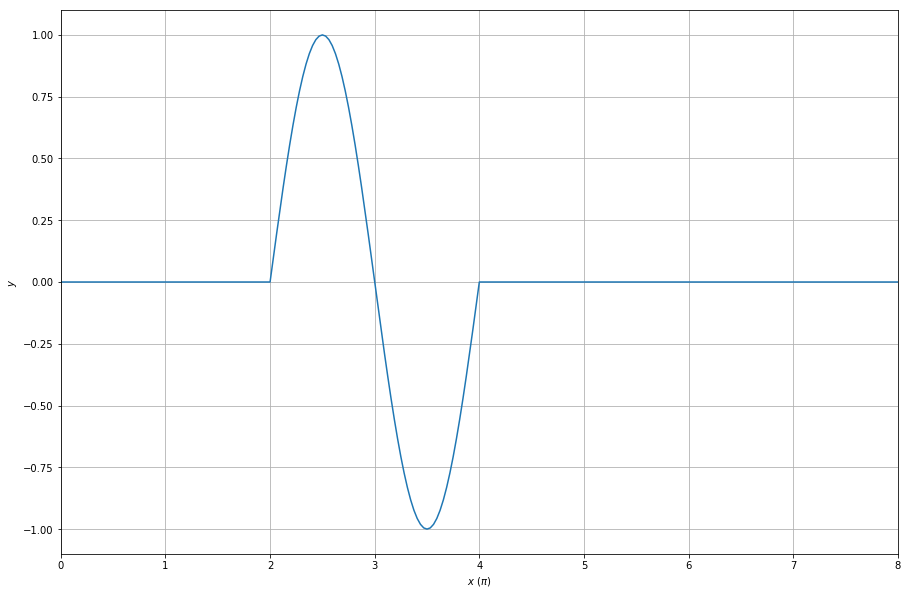

In [9]:
grid = libst.Grid(0, 4*2*np.pi, 4*64)
cfl = 1
dx = (grid.xmax - grid.xmin) / grid.ncelm
dt = dx * cfl
svr = libst.LinearScalarSolver(grid=grid, time_increment=dt)

# Initialize
for e in svr.selms(odd_plane=False): # NOTE: 'selms' returns a template instance of SolverElementIterator
    if e.xctr < 2*np.pi or e.xctr > 2*2*np.pi:
        v = 0
        dv = 0
    else:
        v = np.sin(e.xctr)
        dv = np.cos(e.xctr)
    e.set_so0(0, v)
    e.set_so1(0, dv)

# Plot it
plt.figure(figsize=(15,10))
plt.xlim((0, 8))
plt.xlabel('$x$ $(\pi)$')
plt.ylabel('$y$')
plt.grid()
plt.plot(svr.xctr() / np.pi, svr.get_so0(0), '-')

# See how Python plays

## Linear wave

The governing equation is

\begin{align*}
\frac{\partial u}{\partial t} + \frac{\partial u}{\partial x} = 0
\end{align*}

We will see a propagating wave from left to right with phase velocity of unity.

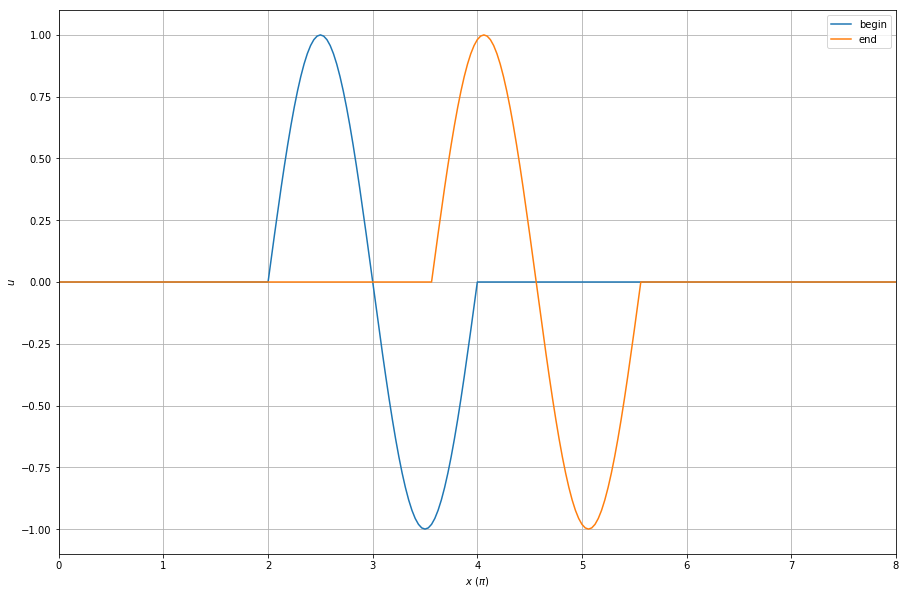

In [10]:
grid = libst.Grid(0, 4*2*np.pi, 4*64)
cfl = 1
dx = (grid.xmax - grid.xmin) / grid.ncelm
dt = dx * cfl
svr = libst.LinearScalarSolver(grid=grid, time_increment=dt)

# Initialize
for e in svr.selms(odd_plane=False):
    if e.xctr < 2*np.pi or e.xctr > 2*2*np.pi:
        v = 0
        dv = 0
    else:
        v = np.sin(e.xctr)
        dv = np.cos(e.xctr)
    e.set_so0(0, v)
    e.set_so1(0, dv)
    

plt.figure(figsize=(15,10))
plt.xlim((0, 8))
plt.xlabel('$x$ $(\pi)$')
plt.ylabel('$u$')
plt.grid()
plt.plot(svr.xctr() / np.pi, svr.get_so0(0), '-', label='begin')

svr.setup_march()
svr.march_alpha2(50)
plt.plot(svr.xctr() / np.pi, svr.get_so0(0), '-', label='end')

plt.legend()

See a movie:

In [11]:
grid = libst.Grid(0, 4*2*np.pi, 4*64)
cfl = 1
dx = (grid.xmax - grid.xmin) / grid.ncelm
dt = dx * cfl
svr = libst.LinearScalarSolver(grid=grid, time_increment=dt)

# Initialize
for e in svr.selms(odd_plane=False):
    if e.xctr < 2*np.pi or e.xctr > 2*2*np.pi:
        v = 0
        dv = 0
    else:
        v = np.sin(e.xctr)
        dv = np.cos(e.xctr)
    e.set_so0(0, v)
    e.set_so1(0, dv)

def animate(nsteps, ninterval):
    fig, ax = plt.subplots(figsize=(15,10))

    ax.set_xlim((svr.selm(0).x/np.pi, svr.selm(svr.grid.ncelm).x/np.pi))
    ax.set_ylim((-1.2, 1.2))
    ax.set_xlabel('$x$ $(\pi)$')
    ax.set_ylabel('$u$')
    ax.grid()

    line, = ax.plot([], [], "-")

    def init():
        svr.setup_march()
        line.set_data(svr.xctr()/np.pi, svr.get_so0(0))
        return (line,)

    def animate(i):
        if i != 0:
            svr.march_alpha2(ninterval)
        line.set_data(svr.xctr()/np.pi, svr.get_so0(0))
        return (line,)

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=nsteps+1, interval=100,
                                   blit=True)
    return HTML(anim.to_jshtml())
            
#animate(100, 10) # Don't check in the animation to git, since it's big.

## The inviscid Burgers equation

The second example is a non-linear equation:

\begin{align*}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = 0
\end{align*}

The wave propagates in a way that is not predictable.

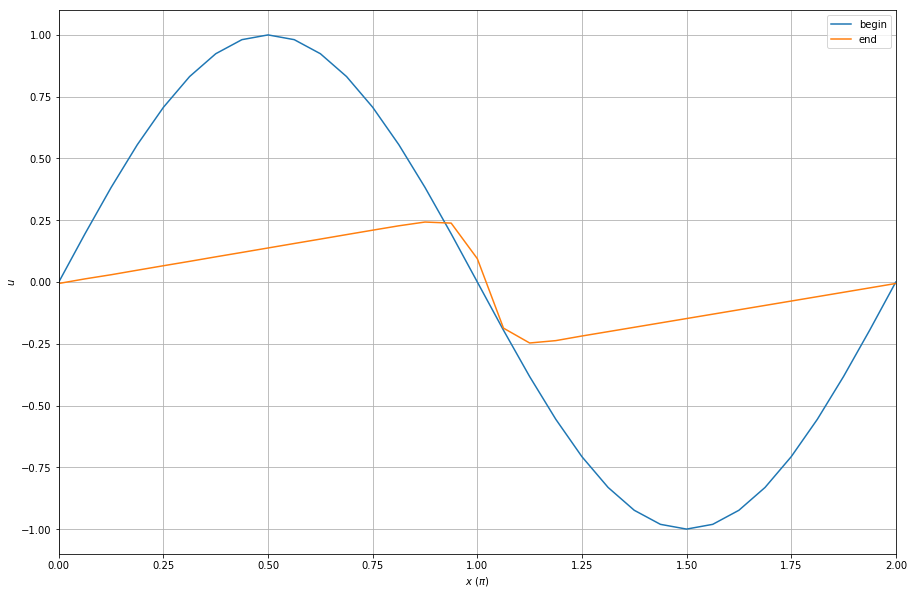

In [12]:
res = 32
xcrd = np.arange(res+1) / res * 2 * np.pi

time_stop = 2*np.pi

grid = libst.Grid(xcrd)
cfl_max = 1.0
dx = (grid.xmax - grid.xmin) / grid.ncelm
dt_max = dx * cfl_max
nstep = int(np.ceil(time_stop / dt_max))
dt = time_stop / nstep
cfl = dt / dx

svr = libst.InviscidBurgersSolver(grid=grid, time_increment=dt)

# Initialize
svr.set_so0(0, np.sin(svr.xctr()))
svr.set_so1(0, np.cos(svr.xctr()))

plt.figure(figsize=(15,10))
plt.xlim((0, 2))
plt.xlabel('$x$ $(\pi)$')
plt.ylabel('$u$')
plt.grid()
plt.plot(svr.xctr() / np.pi, svr.get_so0(0), '-', label='begin')

svr.setup_march()
svr.march_alpha2(50)
plt.plot(svr.xctr() / np.pi, svr.get_so0(0), '-', label='end')

plt.legend()

In [13]:
res = 32
xcrd = np.arange(res+1) / res * 2 * np.pi

time_stop = 2*np.pi

grid = libst.Grid(xcrd)
cfl_max = 1.0
dx = (grid.xmax - grid.xmin) / grid.ncelm
dt_max = dx * cfl_max
nstep = int(np.ceil(time_stop / dt_max))
dt = time_stop / nstep
cfl = dt / dx

svr = libst.InviscidBurgersSolver(grid=grid, time_increment=dt)

# Initialize
svr.set_so0(0, np.sin(svr.xctr()))
svr.set_so1(0, np.cos(svr.xctr()))

def animate(nsteps):
    fig, ax = plt.subplots(figsize=(15,10))

    ax.set_xlim((svr.selm(0).x/np.pi, svr.selm(svr.grid.ncelm).x/np.pi))
    ax.set_ylim((-1.2, 1.2))
    ax.set_xlabel('$x$ $(\pi)$')
    ax.set_ylabel('$u$')
    ax.grid()

    line, = ax.plot([], [], "+-")

    def init():
        svr.setup_march()
        line.set_data(svr.xctr()/np.pi, svr.get_so0(0))
        return (line,)

    def animate(i):
        if i != 0:
            svr.march_alpha2(1)
        line.set_data(svr.xctr()/np.pi, svr.get_so0(0))
        return (line,)

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=nsteps+1, interval=100,
                                   blit=True)
    return HTML(anim.to_jshtml())
            
#animate(50) # Don't check in the animation to git, since it's big.

# Manipulate Python objects in C++

Pybind11 provides C++ API for manipulating Python object (the C `struct PyObject`), so that we don't need to dig into the Python C API and worry about the reference counting by hand.

The first example is to create a `None` object from C++.

In [14]:
%%pybind11 -c="-O3"

#include "pybind11/pybind11.h"

PYBIND11_MODULE(code_none, m)
{
    namespace py = pybind11;

    m
        .def
        (
            "create_none", []() { return py::none(); }
        )
    ;
}

In [15]:
print(create_none)
print(type(create_none()))
print(create_none())

<built-in method create_none of PyCapsule object at 0x1083b5690>
<class 'NoneType'>
None


`pybind11::object` is the C++ counterpart of `PyObject` in C, but automatically does reference counting for us.

In [16]:
%%pybind11 -c="-O3"

#include "pybind11/pybind11.h"

PYBIND11_MODULE(code_object, m)
{
    namespace py = pybind11;

    m
        .def
        (
            "return_none"
          , []()
            {
                py::object ret = py::none();
                return ret;
            }
        )
    ;
}

In [17]:
print(return_none, return_none())

<built-in method return_none of PyCapsule object at 0x10894cc90> None


Pybind11 allows us to use `pybind11.attr` to assign attribute to a Python object.

In [18]:
%%pybind11 -c="-O3"

#include "pybind11/pybind11.h"

PYBIND11_MODULE(code_attr, m)
{
    namespace py = pybind11;

    m.attr("string_name") = "string_content";
}

In [19]:
print(type(string_name), string_name)

<class 'str'> string_content


We may use the pybind11 C

In [20]:
%%pybind11 -c="-O3"

#include "pybind11/pybind11.h"

PYBIND11_MODULE(code1, m)
{
    namespace py = pybind11;

    m
        .def
        (
            "create_none", []() { return py::none(); }
        )
        .def
        (
            "return_none"
          , []()
            {
                py::object ret = py::none();
                return ret;
            }
        )
        .def
        (
            "return_numpy_version"
          , []()
            {
                py::object numpy = py::module::import("numpy");
                return numpy.attr("__version__");
            }
        )
    ;
    
    m.attr("string_name") = "string_content";
    
    m.attr("alias_to_return_none") = m.attr("return_none");
}

In [21]:
print(create_none, create_none())
print(return_none, return_none())
print(return_numpy_version())
print(type(string_name), string_name)
print(alias_to_return_none, alias_to_return_none())

<built-in method create_none of PyCapsule object at 0x1083ae4b0> None
<built-in method return_none of PyCapsule object at 0x1083ae5d0> None
1.17.0.dev0+3c3ba10
<class 'str'> string_content
<built-in method return_none of PyCapsule object at 0x1083ae5d0> None


# Python containers

Pybind11 provides C++ API for creating and manipulating the most important Python containers: `tuple`, `list`, and `dict`.  See https://pybind11.readthedocs.io/en/stable/advanced/pycpp/object.html and the unit tests for more information.

## `tuple`

In [22]:
%%pybind11 -c="-O3"

#include "pybind11/pybind11.h"

PYBIND11_MODULE(code_tuple, m)
{
    namespace py = pybind11;

    py::tuple my_tuple = py::make_tuple("string_data_in_tuple", 10, 3.1415926);

    m.attr("my_tuple") = my_tuple;
}

In [23]:
print(type(my_tuple), my_tuple)

<class 'tuple'> ('string_data_in_tuple', 10, 3.1415926)


## `list`

In [24]:
%%pybind11 -c="-O3"

#include "pybind11/pybind11.h"

PYBIND11_MODULE(code2, m)
{
    namespace py = pybind11;

    py::list my_list = py::list();

    my_list.append("string_data_in_list");
    my_list.append(11);
    my_list.append(2.71828);

    py::list my_list2 = py::make_tuple("string_data_in_list2", 12);

    m.attr("my_list") = my_list;
    m.attr("my_list2") = my_list2;
}

In [25]:
print(type(my_list), my_list)

<class 'list'> ['string_data_in_list', 11, 2.71828]


In [26]:
print(type(my_list2), my_list2)

<class 'list'> ['string_data_in_list2', 12]


## `dict`

In [27]:
%%pybind11 -c="-O3"

#include "pybind11/pybind11.h"

PYBIND11_MODULE(code2, m)
{
    namespace py = pybind11;

    py::dict my_dict;

    my_dict["key_string"] = "string_data_in_dict";
    my_dict["key_int"] = 13;
    my_dict["key_real"] = 1.414;

    m.attr("my_dict") = my_dict;
}

In [28]:
print(type(my_dict), my_dict)

<class 'dict'> {'key_string': 'string_data_in_dict', 'key_int': 13, 'key_real': 1.414}


# Exercises

# References

1. S.C. Chang, "The Method of Space-Time Conservation Element and Solution Element -- A New Approach for Solving the Navier-Stokes and Euler Equations," J. Comput. Phys., 119, pp. 295-324, (1995).  DOI: [10.1006/jcph.1995.1137](https://doi.org/10.1006/jcph.1995.1137)